# Libs import

In [3]:
import json
api_token = {"username":"iobananaoi","key":"84cda1d87e243a61b9694f0ef68dc326"}


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [83]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader
from kaggle.api.kaggle_api_extended import KaggleApi
from torchvision import transforms
from zipfile import ZipFile
from PIL import Image
from torchvision import models
from functools import reduce

In [5]:
api = KaggleApi()
api.authenticate()

In [6]:
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

 99% 1.03G/1.04G [00:09<00:00, 81.4MB/s]
100% 1.04G/1.04G [00:09<00:00, 114MB/s] 


In [7]:
with ZipFile("/content/flickr8kimagescaptions.zip") as f:
    f.extractall()

# Essential variables

In [8]:
batch_size = 32

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data processing

### Dataset

In [281]:
class Flickr8k(Dataset):
    def __init__(self, img_path="/content/flickr8k/images/", transform=None, train=True):
        self.df = pd.read_csv('/content/flickr8k/captions.txt', sep=",")
        self.df = self.df[:30000] if train else self.df[30000:]

        self.vocab = set([word.lower() for caption in self.df["caption"] for word in caption.split(" ")])
        self.symb2idx = {list(self.vocab)[i]: i for i in range(len(self.vocab))}
        self.idx2symb = {i: list(self.vocab)[i] for i in range(len(self.vocab))}

        self.transform = transform
        self.img_path = img_path

    def convert_label2idxs(self, label: str) -> list:
        return [self.symb2idx[symb] for symb in label.split(" ")]
    
    def convert_idxs2label(self, idxs: list) -> str:
        symbs_list = [self.idx2symb[idx] for idx in idxs]
        return reduce(lambda x, y: x + " " + y, symbs_list)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, caption = self.df.iloc[idx]["image"], self.df.iloc[idx]["caption"]
        img = Image.open(self.img_path+img_name)

        if self.transform is not None:
            img = self.transform(img)

        return img, caption

In [282]:
transform = transforms.Compose([
    transforms.CenterCrop(300),
    transforms.ToTensor(),
])

train_ds, test_ds = Flickr8k(train=True, transform=transform), Flickr8k(train=False, transform=transform)

### DataLoader

In [264]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, drop_last=True)

In [265]:
def make_grid(images, caps, nrows=3, ncols=3):
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 13))
    for i in range(ncols*nrows):
        row = i // ncols
        col = i % ncols
        img = images[i].cpu().squeeze().permute(1, 2, 0)

        ax[row, col].set_title(caps[i])
        ax[row, col].imshow(img)

    plt.show()

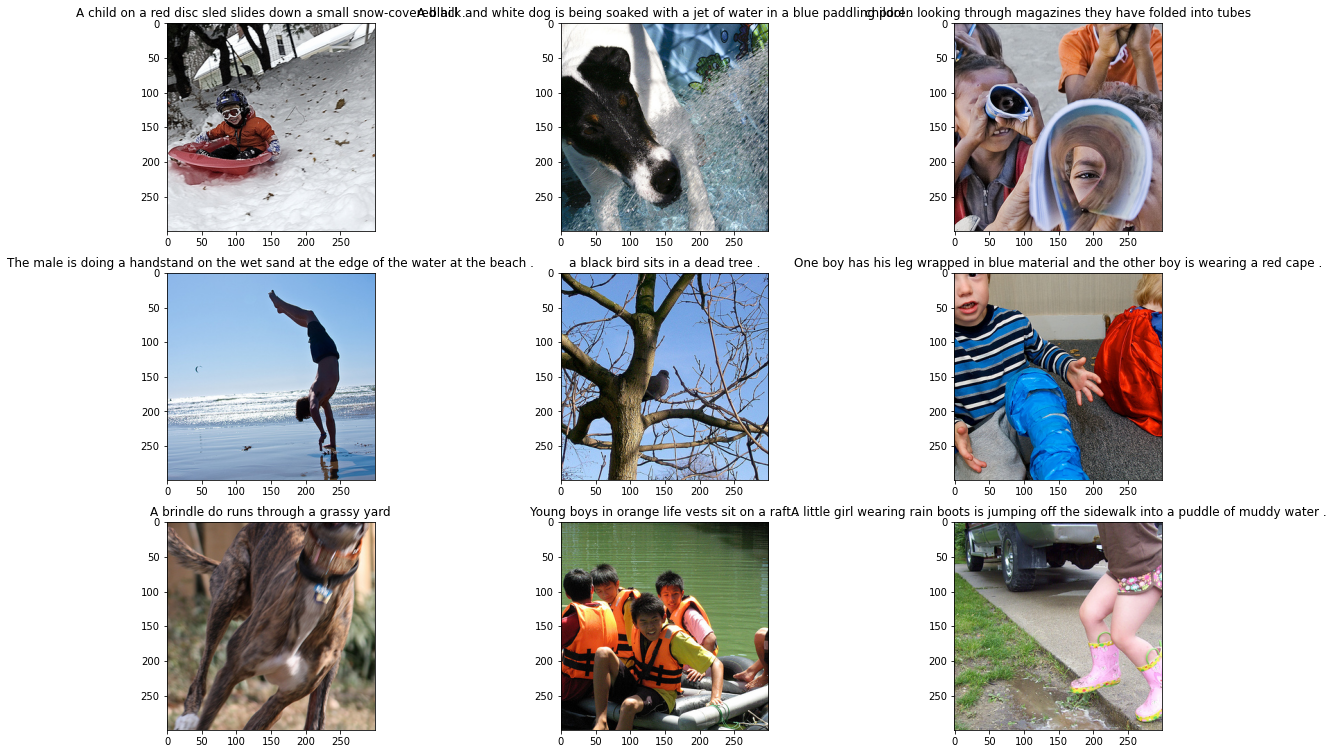

In [266]:
imgs, caps = next(iter(train_dl))
make_grid(imgs, caps)

# Model architecture

In [267]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    
    def forward(self, x):
        x = self.resnet(x)
        x = x.permute(0, 2, 3, 1) # [batch_size, 10, 10, 2048]
        x = x.view(x.size(0), -1, x.size(-1)) #(batch_size, 100, 2048)

        return x 

In [268]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, vocab_size):
        super(Decoder, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, vocab_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)

    def forward(self, x):
        rnn_output, _ = self.lstm(x)
        features = torch.stack([nn.functional.softmax(self.linear(rnn_output[i]), dim=-1) for i in range(rnn_output.shape[0])])
        
        return features

In [269]:
class Enc2Dec(nn.Module):
    def __init__(self, enc_out_dim, dec_hid_dim, vocab_size):
        super(Enc2Dec, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder(enc_out_dim, dec_hid_dim, vocab_size)

    def forward(self, input):
        enc_out = self.encoder(input)
        dec_out = self.decoder(enc_out)

        return dec_out

In [270]:
enc_out_dim = 2048
dec_hid_dim = 50
vocab_size = len(train_ds.vocab)
embed_size = 80

loss_fn = nn.CrossEntropyLoss()

In [271]:
net = Enc2Dec(enc_out_dim, dec_hid_dim, vocab_size)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [272]:
res = net(imgs)

In [273]:
t = train_ds.convert_label2idxs(caps[0].lower())

In [274]:
t = torch.Tensor(t)
t = t.to(torch.int)

In [275]:
y = nn.Embedding(len(t), vocab_size)

In [278]:
words_idx = res[0].argmax(dim=1).tolist()

In [283]:
words = train_ds.convert_idxs2label(words_idx)

In [285]:
len(words)

815

In [260]:
len(train_ds.vocab)

7788

In [288]:
res[0].shape

torch.Size([100, 7788])